In [1]:
import os
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.onnx
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from torchinfo import summary

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE: ", DEVICE)
BATCH_SIZE = 32
WEIGHT_DECAY = 0
EPOCHS = 50

DEVICE:  cpu



# Create Loader of Dataset

In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((88, 88)), transforms.ToTensor()])

In [4]:
class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=4, B=2, C=1, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        boxes = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("L")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])
                boxes.append([class_label, x, y, width, height])

        if len(boxes) > 3:
            boxes = boxes[:3]
            centers = centers[:3]

        boxes = torch.tensor(boxes)
        centers = torch.tensor(centers)
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1

        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix , boxes

In [5]:
def collate_fn(batch):
    images = []
    label_matrices = []
    boxes_list = []
    for item in batch:
        images.append(item[0])
        label_matrices.append(item[1])
        boxes_list.append(item[2])
    images = torch.stack(images)
    label_matrices = torch.stack(label_matrices)
    return images, label_matrices, boxes_list


In [6]:
from torch.utils.data import random_split

files_dir = '/home/buono/ObjDct_Repo/data/ShipDataset'

train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=True
)


# Define the length of the training set and validation set
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

# Split the dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_len, val_len])


# Now you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=collate_fn, num_workers=15)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=15)


In [7]:
test_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=15)

In [8]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(25426, 6357, 7946)

# Utility Functions

## Euclidean Distance between centers

In [9]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

## mAP

In [10]:
def is_center_inside_bbox(center, bbox):
    """
    Check if a center (x, y) is inside a bounding box (x, y, w, h).
    Parameters:
        center (tuple): The (x, y) coordinates of the center.
        bbox (tuple): The (x, y, w, h) coordinates of the bounding box.
    Returns:
        bool: True if the center is inside the bounding box, False otherwise.
    """
    center_x, center_y = center
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    bbox_x_min = bbox_x - bbox_w / 2
    bbox_x_max = bbox_x + bbox_w / 2
    bbox_y_min = bbox_y - bbox_h / 2
    bbox_y_max = bbox_y + bbox_h / 2

    return bbox_x_min <= center_x <= bbox_x_max and bbox_y_min <= center_y <= bbox_y_max


def mean_average_precision(
    pred_boxes, true_boxes, num_classes=1
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bbox
        specified as [train_idx, class_prediction, prob_score, x_center, y_center]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        specified as [train_idx, class_label, x, y, w, h]
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_match = False

            for idx, gt in enumerate(ground_truth_img):
                if is_center_inside_bbox(detection[3:5], gt[2:]):
                    best_match = True
                    best_gt_idx = idx
                    break

            if best_match:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)



## NMS

In [27]:
def non_max_suppression(centers):

    assert type(centers) == list
    centers = [center for center in centers if center[1]> 0]
    centers = sorted(centers, key=lambda x: x[1], reverse=True)
    centers_after_nms = []

    while centers:
        current_center = centers.pop(0)
        centers_after_nms.append(current_center)
        break

    return centers_after_nms


## Get and convert centers

In [12]:
def convert_cellcenters(predictions, S=4, C=1):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]

    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )

    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

In [13]:
def cellcenters_to_centers(out, S=4):
    """
    Converts cell centers to centers
    """
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)

    return all_centers

In [14]:
def get_bboxes(
    loader,
    model,
    device,
):
    all_pred_centers = []
    all_true_centers = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels, boxes_list) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)


        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels) 
        pred_centers = cellcenters_to_centers(predictions) 
        
        for idx in range(batch_size):

            boxes = boxes_list[idx].to(device)

            nms_centers= non_max_suppression(
                pred_centers[idx]
            )

            for center in nms_centers:
                all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > 0:
                    all_true_centers.append([train_idx] + center)

            for box in boxes:
                all_true_boxes.append([train_idx] + box.tolist())

            train_idx += 1

    return all_pred_centers, all_true_centers, all_true_boxes

## YOLO Loss

In [15]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=4, B=2, C=1):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        iou_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        ious = torch.cat([iou_c1.unsqueeze(0), iou_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestcenter = torch.max(ious, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Define Model

In [16]:
class LinearActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 1) + torch.pow(t,2)

### Model 1

In [17]:
class TinyissimoYOLO(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 12, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12*4*4, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # print(x.shape)
        x = self.fclayers(x)

        return x
    
    def training_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


model = TinyissimoYOLO()

summary(model, input_size=(1, 1, 88, 88))

Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLO                           [1, 112]                  --
├─Sequential: 1-1                        [1, 4, 21, 21]            --
│    └─Conv2d: 2-1                       [1, 4, 42, 42]            104
│    └─LinearActivation: 2-2             [1, 4, 42, 42]            --
│    └─AvgPool2d: 2-3                    [1, 4, 21, 21]            --
├─Sequential: 1-2                        [1, 12, 4, 4]             --
│    └─Conv2d: 2-4                       [1, 12, 9, 9]             1,212
│    └─LinearActivation: 2-5             [1, 12, 9, 9]             --
│    └─AvgPool2d: 2-6                    [1, 12, 4, 4]             --
├─Sequential: 1-3                        [1, 112]                  --
│    └─Flatten: 2-7                      [1, 192]                  --
│    └─Linear: 2-8                       [1, 256]                  49,408
│    └─LinearActivation: 2-9             [1, 256]                  --
│    └─

### Model 2

In [18]:
class SimilarYOLO1(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, stride=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12*3*3, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

model1 = SimilarYOLO1()
summary(model1, input_size=(1, 1, 88, 88))


Layer (type:depth-idx)                   Output Shape              Param #
SimilarYOLO1                             [1, 112]                  --
├─Sequential: 1-1                        [1, 4, 21, 21]            --
│    └─Conv2d: 2-1                       [1, 4, 42, 42]            104
│    └─LinearActivation: 2-2             [1, 4, 42, 42]            --
│    └─AvgPool2d: 2-3                    [1, 4, 21, 21]            --
├─Sequential: 1-2                        [1, 8, 9, 9]              --
│    └─Conv2d: 2-4                       [1, 8, 19, 19]            296
│    └─LinearActivation: 2-5             [1, 8, 19, 19]            --
│    └─AvgPool2d: 2-6                    [1, 8, 9, 9]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-7                       [1, 12, 7, 7]             876
│    └─LinearActivation: 2-8             [1, 12, 7, 7]             --
│    └─AvgPool2d: 2-9                    [1, 12, 3, 3]             --
├─Sequential

### Model 3

In [19]:
class SimilarYOLO2(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 12, kernel_size=3, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12*5*5, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

model2 = SimilarYOLO2()
summary(model2, input_size=(1, 1, 88, 88))


Layer (type:depth-idx)                   Output Shape              Param #
SimilarYOLO2                             [1, 112]                  --
├─Sequential: 1-1                        [1, 6, 21, 21]            --
│    └─Conv2d: 2-1                       [1, 6, 42, 42]            156
│    └─LinearActivation: 2-2             [1, 6, 42, 42]            --
│    └─AvgPool2d: 2-3                    [1, 6, 21, 21]            --
├─Sequential: 1-2                        [1, 12, 5, 5]             --
│    └─Conv2d: 2-4                       [1, 12, 10, 10]           660
│    └─LinearActivation: 2-5             [1, 12, 10, 10]           --
│    └─AvgPool2d: 2-6                    [1, 12, 5, 5]             --
├─Sequential: 1-3                        [1, 112]                  --
│    └─Flatten: 2-7                      [1, 300]                  --
│    └─Linear: 2-8                       [1, 256]                  77,056
│    └─LinearActivation: 2-9             [1, 256]                  --
│    └─Li

### Model 4

In [20]:
class SimilarYOLO3(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*9*9, 512),
            LinearActivation(),
            nn.Linear(512, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

model3 = SimilarYOLO3()
summary(model3, input_size=(1, 1, 88, 88))


Layer (type:depth-idx)                   Output Shape              Param #
SimilarYOLO3                             [1, 112]                  --
├─Sequential: 1-1                        [1, 4, 21, 21]            --
│    └─Conv2d: 2-1                       [1, 4, 42, 42]            104
│    └─LinearActivation: 2-2             [1, 4, 42, 42]            --
│    └─AvgPool2d: 2-3                    [1, 4, 21, 21]            --
├─Sequential: 1-2                        [1, 8, 9, 9]              --
│    └─Conv2d: 2-4                       [1, 8, 19, 19]            296
│    └─LinearActivation: 2-5             [1, 8, 19, 19]            --
│    └─AvgPool2d: 2-6                    [1, 8, 9, 9]              --
├─Sequential: 1-3                        [1, 112]                  --
│    └─Flatten: 2-7                      [1, 648]                  --
│    └─Linear: 2-8                       [1, 512]                  332,288
│    └─LinearActivation: 2-9             [1, 512]                  --
│    └─L

### Model 5

In [21]:
class SimilarYOLO4(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 10, kernel_size=3, stride=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*9*9, 512),
            LinearActivation(),
            nn.Linear(512, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

model4 = SimilarYOLO4()
summary(model4, input_size=(1, 1, 88, 88))


Layer (type:depth-idx)                   Output Shape              Param #
SimilarYOLO4                             [1, 112]                  --
├─Sequential: 1-1                        [1, 6, 21, 21]            --
│    └─Conv2d: 2-1                       [1, 6, 42, 42]            156
│    └─LinearActivation: 2-2             [1, 6, 42, 42]            --
│    └─AvgPool2d: 2-3                    [1, 6, 21, 21]            --
├─Sequential: 1-2                        [1, 10, 9, 9]             --
│    └─Conv2d: 2-4                       [1, 10, 19, 19]           550
│    └─LinearActivation: 2-5             [1, 10, 19, 19]           --
│    └─AvgPool2d: 2-6                    [1, 10, 9, 9]             --
├─Sequential: 1-3                        [1, 112]                  --
│    └─Flatten: 2-7                      [1, 810]                  --
│    └─Linear: 2-8                       [1, 512]                  415,232
│    └─LinearActivation: 2-9             [1, 512]                  --
│    └─L

# Training

In [ ]:
loss_fn = YoloLoss()

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="val_loss", 
                                      mode="min")
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(accelerator=DEVICE, 
                    callbacks=[checkpoint_callback, lr_monitor_callback], 
                    max_epochs=EPOCHS, 
                    enable_progress_bar=True, 
                    enable_model_summary=True)

In [ ]:
os.makedirs("lightning_logs", exist_ok=True)

In [ ]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
model.eval()
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model, DEVICE
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")
torch.save(model.state_dict(), "../../models/trained_models/LeNetYOLO.pth")

## Create other models for ensemble

In [ ]:
loss_fn = YoloLoss()

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="val_loss", 
                                      mode="min")
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(accelerator=DEVICE, 
                    callbacks=[checkpoint_callback, lr_monitor_callback], 
                    max_epochs=EPOCHS, 
                    enable_progress_bar=True, 
                    enable_model_summary=True)

os.makedirs("lightning_logs", exist_ok=True)

trainer.fit(model=model1, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
model1.eval()
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model1, DEVICE
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")
torch.save(model1.state_dict(), "../../models/trained_models/LeNetYOLO_1.pth")

In [ ]:
loss_fn = YoloLoss()

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="val_loss", 
                                      mode="min")
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(accelerator=DEVICE, 
                    callbacks=[checkpoint_callback, lr_monitor_callback], 
                    max_epochs=EPOCHS, 
                    enable_progress_bar=True, 
                    enable_model_summary=True)

os.makedirs("lightning_logs", exist_ok=True)

trainer.fit(model=model2, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
model2.eval()
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model2, DEVICE
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")
torch.save(model2.state_dict(), "../../models/trained_models/LeNetYOLO_2.pth")

In [ ]:
loss_fn = YoloLoss()

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="val_loss", 
                                      mode="min")
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(accelerator=DEVICE, 
                    callbacks=[checkpoint_callback, lr_monitor_callback], 
                    max_epochs=EPOCHS, 
                    enable_progress_bar=True, 
                    enable_model_summary=True)

os.makedirs("lightning_logs", exist_ok=True)
trainer.fit(model=model3, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
model3.eval()
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model3, DEVICE
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")
torch.save(model3.state_dict(), "../../models/trained_models/LeNetYOLO_3.pth")

In [ ]:
loss_fn = YoloLoss()

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="val_loss", 
                                      mode="min")
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(accelerator=DEVICE, 
                    callbacks=[checkpoint_callback, lr_monitor_callback], 
                    max_epochs=EPOCHS, 
                    enable_progress_bar=True, 
                    enable_model_summary=True)

os.makedirs("lightning_logs", exist_ok=True)
trainer.fit(model=model4, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
model4.eval()
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model4, DEVICE
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")
torch.save(model4.state_dict(), "../../models/trained_models/LeNetYOLO_4.pth")

# Ensemble

## Load Models

In [22]:
models = []
model = TinyissimoYOLO()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO.pth")
model.load_state_dict(checkpoint)
model.eval()
models.append(model)

model_1 = SimilarYOLO1()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO_1.pth")
model_1.load_state_dict(checkpoint)
model_1.eval()
models.append(model_1)

model_2 = SimilarYOLO2()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO_2.pth")
model_2.load_state_dict(checkpoint)
model_2.eval()
models.append(model_2)

model_3 = SimilarYOLO3()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO_3.pth")
model_3.load_state_dict(checkpoint)
model_3.eval()
models.append(model_3)

model_4 = SimilarYOLO4()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO_4.pth")
model_4.load_state_dict(checkpoint)
model_4.eval()
models.append(model_4)


## Create average predictions

In [28]:
pred_boxes_list = []
with torch.no_grad():
    pred_boxes_1, target_boxes, real_boxes_1 = get_bboxes(
        test_loader, model, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_1, real_boxes_1)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_1)

    pred_boxes_2, target_boxes, real_boxes_2 = get_bboxes(
        test_loader, model_1, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_2, real_boxes_2)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_2)

    pred_boxes_3, target_boxes, real_boxes_3 = get_bboxes(
        test_loader, model_2, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_3, real_boxes_3)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_3)

    pred_boxes_4, target_boxes, real_boxes_4 = get_bboxes(
        test_loader, model_3, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_4, real_boxes_4)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_4)

    pred_boxes_5, target_boxes, real_boxes_5 = get_bboxes(
        test_loader, model_4, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_5, real_boxes_5)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_5)
    


mAP: 0.34433412551879883
mAP: 0.5381021499633789
mAP: 0.6072299480438232
mAP: 0.5122708082199097
mAP: 0.5981251001358032


In [29]:
print(real_boxes_1[0])
print(real_boxes_2[0])
print(real_boxes_3[0])

[0, 0.0, 0.951171875, 0.04296875, 0.06640625, 0.0546875]
[0, 0.0, 0.951171875, 0.04296875, 0.06640625, 0.0546875]
[0, 0.0, 0.951171875, 0.04296875, 0.06640625, 0.0546875]


In [30]:
real_boxes_1 = np.array(real_boxes_1)
real_boxes_2 = np.array(real_boxes_2)
real_boxes_3 = np.array(real_boxes_3)
real_boxes_4 = np.array(real_boxes_4)
real_boxes_5 = np.array(real_boxes_5)

In [31]:
pred_boxes_list = np.array(pred_boxes_list)
pred_boxes_list.shape

(5, 7946, 5)

In [32]:
def ensemble_center_predictions_weighted(predictions):
    """
    Ensemble predictions from multiple models by averaging center coordinates and confidence scores
    with specific weights for each model.

    Parameters:
        predictions (numpy.ndarray): Array of shape (num_models, num_predictions, 5) containing
                                     the predictions from each model. Each prediction is in the
                                     format [predicted_class, best_confidence, x_center, y_center].
        
    Returns:
        numpy.ndarray: Array of ensemble predictions with weights applied.
    """
    # Define weights for each model
    weights = np.array([0.15,0.2,0.25,0.2,0.2])
    
    def average_predictions_weighted(predictions):
        # Apply weights to confidence scores and center coordinates
        weighted_confidences = np.average(predictions[:, 1], axis=0, weights=weights)
        weighted_centers = np.average(predictions[:, 2:], axis=0, weights=weights)
        
        # Assuming class_ids are the same for all models, take the class_id from the first model
        class_id = predictions[0, 0]
        
        return np.array([class_id, weighted_confidences, *weighted_centers])
    
    all_predictions = []
    
    for i in range(predictions.shape[1]):  # Iterate over each prediction index
        single_prediction = predictions[:, i, :]
        ensembled_prediction = average_predictions_weighted(single_prediction)
        all_predictions.append(ensembled_prediction)
    
    return np.array(all_predictions)

# Example usage
predictions = np.random.rand(5, 7946, 5)  # Example array with predictions
ensembled_predictions = ensemble_center_predictions_weighted(predictions)
print(ensembled_predictions.shape)


(7946, 5)


In [33]:
ensembled_predictions = ensemble_center_predictions_weighted(pred_boxes_list)
mAP = mean_average_precision(ensembled_predictions, real_boxes_1)
print(f"mAP: {mAP}")

mAP: 0.5011073350906372


## Plot test results and statistics

In [ ]:
# def plot_centers(idx, pred_centers, target_centers):
#     values = test_dataset[idx]
#     image = values[0]
#     image = image.permute(1, 2, 0).to("cpu")

#     image = np.array(image)
#     height, width, _ = image.shape
#     p_centers = []
#     t_centers = []
#     for center in pred_centers:
#         if center[0] == idx:
#             p_centers.append(center[1:])

#     for center in target_centers:
#         if center[0] == idx:
#             t_centers.append(center[1:])


#     fig, ax = plt.subplots()
#     ax.imshow(image)
#     for center in p_centers:
#         rect = patches.Rectangle(
#             (center[2] * width , center[3] * height),
#             1,
#             1,
#             linewidth=5,
#             edgecolor="r",
#             facecolor="none",
#         )
#         ax.add_patch(rect)
#     # Create a Rectangle patch
#     for boxes in t_centers:
#         class_label = int(boxes[0])
#         box = boxes[1:]
#         assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
#         upper_left_x = box[0] - box[2] / 2
#         upper_left_y = box[1] - box[3] / 2
#         rect = patches.Rectangle(
#             (upper_left_x * width, upper_left_y * height),
#             box[2] * width,
#             box[3] * height,
#             linewidth=1,
#             edgecolor="r",
#             facecolor="none",
#         )
#         # Add the patch to the Axes
#         ax.add_patch(rect)

#         # Add class label text
#         ax.text(upper_left_x * width, upper_left_y * height, str(class_label), color='r', fontsize=10, verticalalignment='bottom')


#     plt.show()

# plot_centers(4, ensembled_predictions, real_boxes_1)

([<matplotlib.axis.XTick at 0x7c96b1c06d70>,
 [Text(0.0, 0, 'Very Small'),
  Text(0.1, 0, 'Small'),
  Text(0.15, 0, 'Medium'),
  Text(0.2, 0, 'Large'),
  Text(0.25, 0, 'Very Large')])

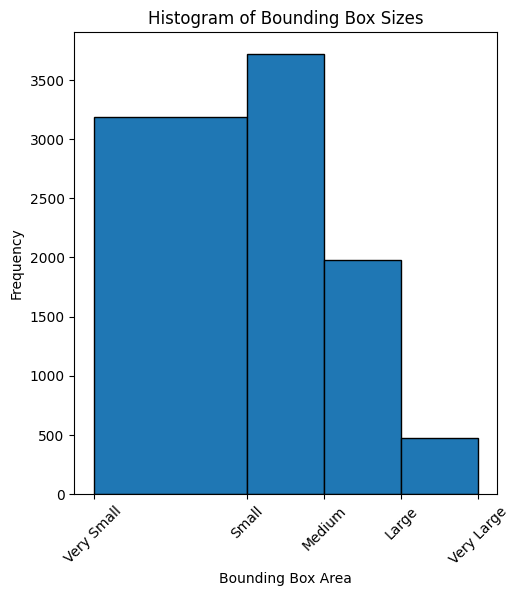

In [34]:
bounding_boxes = np.array(real_boxes_1)[:,2:]
bounding_boxes

areas = np.sqrt([width * height for (x_center, y_center, width, height) in bounding_boxes])

# Raggruppamento delle bounding box per dimensione
bins = [0, 0.1, 0.15, 0.2, 0.25]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
box_sizes = np.digitize(areas, bins=bins, right=True)

# Creazione dell'istogramma delle dimensioni delle bounding box
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(areas, bins=bins, edgecolor='black')
plt.title('Histogram of Bounding Box Sizes')
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.xticks(ticks=bins, labels=labels, rotation=45)


## Ensemble Distances

In [35]:
def get_distances(predictions, real_boxes):
    distances = []
    for idx_p, _ ,_ ,x_p, y_p in predictions:
        for idx_b,_, x_center, y_center, width, height in real_boxes:
            if idx_p == idx_b:
                x_left = x_center - width / 2
                x_right = x_center + width / 2
                y_top = y_center - height / 2
                y_bottom = y_center + height / 2

                dist_left = abs(x_p - x_left) if x_p < x_left else float('inf')
                dist_right = abs(x_p - x_right) if x_p > x_right else float('inf')
                dist_top = abs(y_p - y_top) if y_p < y_top else float('inf')
                dist_bottom = abs(y_p - y_bottom) if y_p > y_bottom else float('inf')

                # Se il punto è all'interno della bounding box, la distanza è zero
                if x_left <= x_p <= x_right and y_top <= y_p <= y_bottom:
                    min_distance = 0
                else:
                    min_distance = min(dist_left, dist_right, dist_top, dist_bottom)

                distances.append(min_distance)

    # Calcolo della distanza media per ciascun gruppo di dimensioni
    distance_means = []
    for i in range(len(bins) - 1):
        group_distances = [dist for dist, size in zip(distances, box_sizes) if size == i + 1]
        if group_distances:
            distance_means.append(np.mean(group_distances))
        else:
            distance_means.append(0)
    
    return distance_means

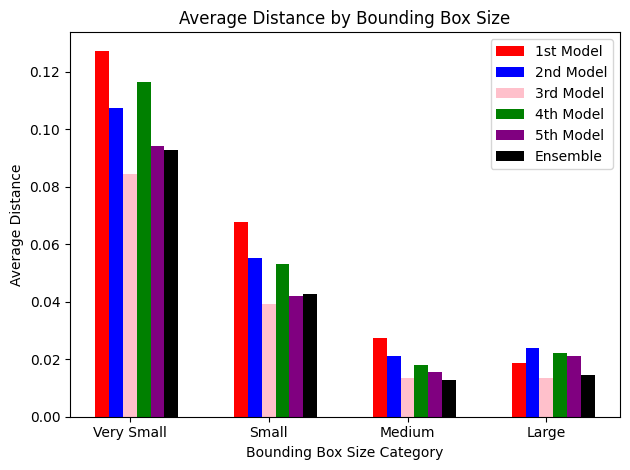

In [36]:
# Creiamo una lista di etichette per le categorie di dimensioni
labels = ['Very Small', 'Small', 'Medium', 'Large']

# Configuriamo il numero di gruppi e il numero di barre per gruppo
x = np.arange(len(labels))
width = 0.1  # Larghezza delle barre

fig, ax = plt.subplots()

# Aggiungiamo le barre per ogni set di distance_means
rects1 = ax.bar(x - 2 * width, get_distances(pred_boxes_1,real_boxes_1), width, label='1st Model', color='red')
rects2 = ax.bar(x - 1 * width, get_distances(pred_boxes_2,real_boxes_2), width, label='2nd Model', color='blue')
rects3 = ax.bar(x - 0 * width, get_distances(pred_boxes_3,real_boxes_3), width, label='3rd Model', color='pink')
rects4 = ax.bar(x + 1 * width, get_distances(pred_boxes_4,real_boxes_4), width, label='4th Model', color='green')
rects5 = ax.bar(x + 2 * width, get_distances(pred_boxes_5,real_boxes_5), width, label='5th Model', color='purple')
rects6 = ax.bar(x + 3 * width, get_distances(ensembled_predictions,real_boxes_1), width, label='Ensemble', color='black')

# Aggiungiamo le etichette, il titolo e la legenda
ax.set_xlabel('Bounding Box Size Category')
ax.set_ylabel('Average Distance')
ax.set_title('Average Distance by Bounding Box Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Aggiungiamo una disposizione più compatta
fig.tight_layout()

plt.show()